## Reading and pre-processing CSV files

First of all I have to Transform raw data files into a usable format for k-NN classification.

Data from each file was segmented into blocks of 1000 samples. Labels were assigned based on motor condition (e.g., healthy, inner-race fault). I Combined all processed data into a single CSV file. And handled missing values by dropping rows with null values.

After doin that i got a clean dataset with 5168 rows and 1001 columns (1000 feature columns and 1 label column).

In [ ]:
import pandas as pd
import numpy as np
import os

# Set the folder path containing all CSV files
folder_path = 'D:\\ML\\data'

# Create an empty list to store DataFrames for each file
output_dfs = []

# Loop through all CSV files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        # Construct the full file path
        file_path = os.path.join(folder_path, file_name)
        print(file_path)
        # Extract the file name without extension
        file_name_without_extension = file_name.split("-")[0]

        # Read the CSV file
        df = pd.read_csv(file_path)

        # Extract the 'Current-A' column
        current_a_data = df[' Current-A']

        # Define the chunk size
        chunk_size = 1000

        # Calculate the number of complete chunks
        num_complete_chunks = len(current_a_data) // chunk_size

        # Create a list to store transposed chunks and corresponding labels
        transposed_chunks_list = []
        labels_list = []

        # Process the data in complete chunks
        for i in range(0, num_complete_chunks * chunk_size, chunk_size):
            # Take a chunk of data
            chunk = current_a_data[i:i + chunk_size]

            # Transpose the chunk into rows
            transposed_chunk = chunk.values.reshape(1, -1)  # 1 row, 143*1000 columns

            # Append the transposed chunk to the list
            transposed_chunks_list.append(transposed_chunk)

            # Assign a label with the file name
            label = f'{file_name_without_extension}'
            labels_list.append(label)

        # Concatenate the list of transposed chunks along a new axis (axis=0)
        output_array = np.concatenate(transposed_chunks_list, axis=0)

        # Create a DataFrame from the concatenated array with a 'Label' column
        output_df = pd.DataFrame(data=output_array, columns=[f'Value_{i}' for i in range(output_array.shape[1])])
        output_df['Label'] = labels_list

        # Append the DataFrame to the list
        output_dfs.append(output_df)

# Concatenate all DataFrames along a new axis (axis=0)
final_output_df = pd.concat(output_dfs, axis=0, ignore_index=True)

# Save the final DataFrame to a new CSV file
final_output_file_path = 'D:\\ML\\data\\output.csv'
final_output_df.to_csv(final_output_file_path, index=False)

# Print a message to indicate that the final file has been saved
print('Final transposed data with labels saved to {}'.format(final_output_file_path))

In [3]:
# Read the CSV file into a DataFrame
df = pd.read_csv('output.csv')

# Check for null values in the DataFrame
null_values =df.isnull().sum()

# Display or print the null values
print("Null Values:\n", null_values)

Null Values:
 Value_0      1
Value_1      1
Value_2      1
Value_3      1
Value_4      1
            ..
Value_996    2
Value_997    2
Value_998    2
Value_999    2
Label        0
Length: 1001, dtype: int64


In [4]:
df = df.dropna(axis = 0)
print(df.isnull().sum(axis = 0))

Value_0      0
Value_1      0
Value_2      0
Value_3      0
Value_4      0
            ..
Value_996    0
Value_997    0
Value_998    0
Value_999    0
Label        0
Length: 1001, dtype: int64


In [5]:
# Read the csv file
transposed_data_combined = pd.read_csv('output.csv')

# Remove the Label column and store the remaining columns
numerical_columns = transposed_data_combined.drop(columns=['Label'])

# Calculate the Euclidean distance matrix
distance_matrix = np.sqrt(np.maximum(0.0, (np.abs(numerical_columns.values)**2).sum(axis=1)[:, None] +
                                    (np.abs(numerical_columns.values)**2).sum(axis=1)[None, :] -
                                    2 * np.abs(numerical_columns.values).dot(np.abs(numerical_columns.values).T)))

# Convert the distance matrix to a pandas DataFrame
df_distance_matrix = pd.DataFrame(distance_matrix, index=numerical_columns.index, columns=numerical_columns.index)

# Print the distance matrix
print(df_distance_matrix)

# Save the distance matrix to a csv file
df_distance_matrix.to_csv('distance_matrix.csv', index=False)

           0          1          2          3          4          5     \
0      0.000000  21.741932  16.734952  11.649487  10.167941  22.478601   
1     21.741932   0.000009  16.991342  30.870421  13.247772   5.739726   
2     16.734952  16.991342   0.000009  19.661304  16.574938  13.265077   
3     11.649487  30.870421  19.661304   0.000000  20.486836  30.091797   
4     10.167941  13.247772  16.574938  20.486836   0.000007  15.858590   
...         ...        ...        ...        ...        ...        ...   
5165  15.728698   6.469774  12.076715  24.492787   8.632709   7.336282   
5166  15.985259   9.860801   7.313172  22.767059  11.706550   7.384835   
5167  10.069142  21.739670   9.168872  10.599615  14.776304  20.007296   
5168   5.517626  23.489704  14.810902   7.585031  13.027121  23.231494   
5169  11.242354  10.690898  12.753691  20.621450   4.341287  12.130740   

           6          7          8          9     ...       5160       5161  \
0     13.674135   4.602743  20.9

## k-NN Model Implementation

Now, I have to implementation KNN without using Libraries.

I use Euclidean distance to compute similarity. Then majority voting among the k-nearest neighbors to determine the class label.

Also i use two Validation Methods:

Hold-out method with an 80-20 train-test split.
10-fold cross-validation for performance robustness.

Grid search was used to determine the optimal value of k. For k=5, the model achieved the best test accuracy. The things that i configured here are:

Accuracy: 19.83%
| Recall: 0.1660
| Precision: 0.1736
| F1 Score: 0.1625

In [68]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

class KNNClassifier:
    def __init__(self, k=3):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        predictions = []
        for x_test_instance in X_test:
            distances = [self.euclidean_distance(x_test_instance, x_train_instance) for x_train_instance in self.X_train]
            nearest_indices = np.argsort(distances)[:self.k]
            nearest_labels = [self.y_train[idx] for idx in nearest_indices]
            predicted_label = self.most_common(nearest_labels)
            predictions.append(predicted_label)
        return predictions

    def euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))

    def most_common(self, lst):
        unique, counts = np.unique(lst, return_counts=True)
        index = np.argmax(counts)
        return unique[index]

# Assuming df is your DataFrame
X = df.iloc[:, :-1].values  # Assuming the last column is the target variable
y = df.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn_classifier = KNNClassifier(k=5)
knn_classifier.fit(X_train, y_train)

# Make predictions on the test set
predictions = knn_classifier.predict(X_test)

# Display the predictions

accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 19.83%


In [7]:
import random
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

def hold_out_split(X, y, test_size=0.2, random_seed=None):
    if random_seed:
        random.seed(random_seed)

    data = list(zip(X, y))
    random.shuffle(data)

    split_index = int(len(data) * (1 - test_size))
    train_data, test_data = data[:split_index], data[split_index:]

    X_train, y_train = zip(*train_data)
    X_test, y_test = zip(*test_data)

    return X_train, X_test, y_train, y_test

# Usage
X_train, X_test, y_train, y_test = hold_out_split(X, y, test_size=0.2, random_seed=42)
knn_classifier = KNNClassifier(k=5)
knn_classifier.fit(X_train, y_train)
# Make predictions on the test set
predictions = knn_classifier.predict(X_test)
# Display the predictions
print(len(predictions))
print(len(y_test))
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")


1034
1034
Accuracy: 19.34%


In [16]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
# Calculate recall
recall = recall_score(y_test, predictions,average='weighted')
# Calculate precision
precision = precision_score(y_test, predictions,average='weighted')
# Calculate F1 Score
f1 = f1_score(y_test, predictions,average='weighted')

print(f"Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, F1 Score: {f1:.4f}")

Accuracy: 0.1660, Recall: 0.1660, Precision: 0.1736, F1 Score: 0.1625


In [14]:
def custom_k_fold_validation(X, y, k=2):
    data = list(zip(X, y))
    np.random.shuffle(data)

    fold_size = len(data) // k
    folds = [data[i:i + fold_size] for i in range(0, len(data), fold_size)]

    for i in range(k):
        test_data = folds[i]
        train_data = [item for j in range(k) if j != i for item in folds[j]]

        X_train, y_train = zip(*train_data)
        X_test, y_test = zip(*test_data)

        yield np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)
        
# Example usage:

accuracies = []
for X_train, X_test, y_train, y_test in custom_k_fold_validation(X, y,2):
    knn_classifier = KNNClassifier(k=5)
    knn_classifier.fit(X_train, y_train)

    # Make predictions on the test set
    predictions = knn_classifier.predict(X_test)

    # Display the predictions
    accuracy = accuracy_score(y_test, predictions)
    accuracies.append(accuracy)
    print(accuracy)
overall_accuracy = np.mean(accuracies)
print(f"Overall Accuracy: {overall_accuracy * 100:.2f}%")


0.1706656346749226
0.1660216718266254
Overall Accuracy: 16.83%


1
0.16563467492260062
0.16873065015479877
3
0.14938080495356038
0.17414860681114552
5
0.13777089783281735
0.14396284829721362
7
0.14938080495356038
0.15557275541795665
9
0.15170278637770898
0.14705882352941177
11
0.13854489164086686
0.14783281733746131
13
0.16253869969040247
0.14009287925696595
15
0.15092879256965944
0.14705882352941177
17
0.14783281733746131
0.14086687306501547
19
0.14938080495356038
0.14086687306501547


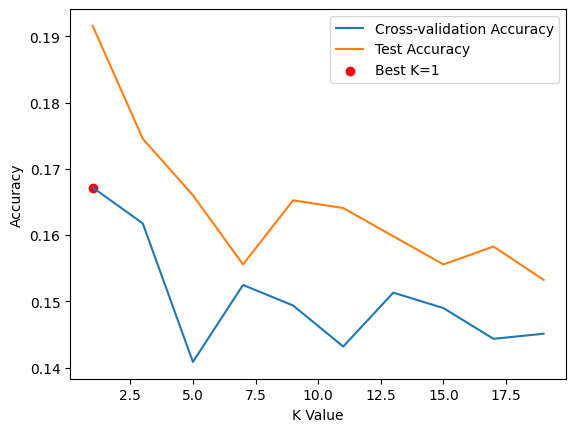

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Define the range of K values to try
k_values = range(1,20,2)

# Lists to store cross-validation and test accuracies
cv_accuracies = []
test_accuracies = []

# Perform grid search
for k in k_values:
    # Lists to store fold accuracies during cross-validation
    fold_accuracies = []
    print(k)
    # Cross-validation loop
    for X_train_fold, X_test_fold, y_train_fold, y_test_fold in custom_k_fold_validation(X_train, y_train, k=2):
        knn_classifier = KNNClassifier(k=k)
        knn_classifier.fit(X_train_fold, y_train_fold)

        # Make predictions on the test set
        predictions_fold = knn_classifier.predict(X_test_fold)

        # Calculate accuracy for this fold
        fold_accuracy = accuracy_score(y_test_fold, predictions_fold)
        print(fold_accuracy)
        fold_accuracies.append(fold_accuracy)

    # Calculate mean cross-validation accuracy for this K
    cv_accuracy = np.mean(fold_accuracies)
    cv_accuracies.append(cv_accuracy)

    # Train the model on the entire training set with the current K
    knn_classifier = KNNClassifier(k=k)
    knn_classifier.fit(X_train, y_train)

    # Make predictions on the test set
    predictions_test = knn_classifier.predict(X_test)

    # Calculate test accuracy for this K
    test_accuracy = accuracy_score(y_test, predictions_test)
    test_accuracies.append(test_accuracy)
best_k = k_values[np.argmax(cv_accuracies)]
best_accuracy = cv_accuracies[np.argmax(cv_accuracies)]


# Plot the results
plt.plot(k_values, cv_accuracies, label='Cross-validation Accuracy')
plt.plot(k_values, test_accuracies, label='Test Accuracy')
plt.scatter([best_k], [best_accuracy], color='red', marker='o', label=f'Best K={best_k}')
plt.xlabel('K Value')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## Dimensionality Reduction (PCA)

Here I applied Principal Component Analysis (PCA) to reduce the dataset's dimensionality and potentially improve classification efficiency.

In it, i do Standardization. So, all feature values were standardized to have a mean of zero and a variance of one. This step ensured me that features with larger scales did not dominate the PCA results.
PCA reduced the original 1000 feature dimensions to 400 components while retaining the maximum variance in the data. This reduced feature set was then used for k-NN classification.

In [18]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming df is your DataFrame
X = df.iloc[:, :-1].values  # Features
labels = df.iloc[:, -1].values

# Standardize the data
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# Apply PCA
n_components = 400  # Adjust the number of components as needed
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_standardized)

# Display the result
print("Original shape:", X.shape)
print("PCA transformed shape:", X_pca.shape)

Original shape: (5168, 1000)
PCA transformed shape: (5168, 400)


In [19]:
import pandas as pd 
labels = pd.DataFrame(labels)
df = pd.DataFrame(X_pca)
df = pd.concat([df, labels], axis=1)
df

,0,1,2,3,4,5,6,7,8,9,...,391,392,393,394,395,396,397,398,399,0
0,-14.070088,14.444532,3.612259,-2.525631,3.138817,-1.371005,0.379139,-0.042569,0.624445,-0.493165,...,0.006374,-0.008170,-0.016338,-0.000580,0.012628,0.007654,0.002452,-0.001630,0.006095,0.7inner
1,35.775684,5.318259,1.177946,0.814503,-0.271495,-0.196072,0.090386,-0.199891,0.037117,0.095888,...,0.005502,0.011966,-0.018969,-0.013461,0.005857,0.014282,0.003603,-0.003696,0.007206,0.7inner
2,4.658914,-19.617464,1.320713,-2.025968,-0.620274,-0.189676,0.040282,0.160529,0.363727,0.382877,...,0.022789,0.016333,0.008436,-0.000114,0.006472,0.001020,0.011363,0.004485,-0.000750,0.7inner
3,-36.534405,0.727754,-2.214485,-0.369549,0.048218,0.281966,0.094266,0.059881,0.382707,0.098685,...,-0.002201,0.003527,-0.005803,-0.009655,0.015517,0.004871,0.006613,0.004206,-0.000302,0.7inner
4,7.927551,18.817217,-0.189799,3.120451,0.004324,-0.187061,0.120216,0.510477,-0.103266,-0.322492,...,-0.006162,0.008898,0.016610,0.023669,-0.001787,0.003372,0.000247,0.007507,0.002221,0.7inner
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5163,20.749804,3.577273,2.464807,0.841943,0.064062,0.039101,-0.025728,-0.016418,0.064831,0.065191,...,-0.008023,0.002175,-0.003996,0.002513,-0.004579,-0.000456,-0.003844,0.002582,0.002609,healthy.csv
5164,16.213170,-7.059750,1.748868,-0.430082,0.179086,0.002812,-0.087477,0.023657,-0.007095,0.182374,...,0.004495,-0.000268,0.004422,0.000173,0.001072,-0.002978,0.004529,-0.007045,-0.003745,healthy.csv
5165,-13.434103,-8.301919,-0.727183,-0.973445,-0.222369,-0.088611,0.135458,-0.125384,-0.023014,-0.120044,...,0.005591,0.007222,0.001889,0.015919,0.000884,0.005412,0.003053,-0.002744,0.007863,healthy.csv
5166,-19.365114,5.188630,-1.249635,0.602375,-0.259649,-0.116375,0.079780,-0.058479,-0.211213,-0.075057,...,-0.005403,-0.007712,-0.003499,0.004312,0.002795,0.002867,-0.002394,-0.002032,-0.003728,healthy.csv


## k-NN Performance

Applying PCA and repeating the optimization process, the optimal k value remained at 5. The performance metrics were as follows:

Accuracy: ~21.37%
| Recall: ~0.1711
| Precision: ~0.1703
| F1 Score: ~0.1688

In [66]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KNeighborsClassifier

class KNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, k=3):
        self.k = k
        self.model = KNeighborsClassifier(n_neighbors=self.k)

    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        return self.model.score(X, y)

    def euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))

    def most_common(self, lst):
        unique, counts = np.unique(lst, return_counts=True)
        index = np.argmax(counts)
        return unique[index]

# Assuming df is your DataFrame
X = df.iloc[:, :-1].values  # Assuming the last column is the target variable
y = df.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn_classifier = KNNClassifier(k=5)
knn_classifier.fit(X_train, y_train)

# Make predictions on the test set
predictions = knn_classifier.predict(X_test)

# Display the predictions
print("Number of predictions:", len(predictions))
print("Number of test samples:", len(X_test))
print("Predictions:", predictions)

# Calculate and display accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")


Number of predictions: 1034
Number of test samples: 1034
Predictions: ['1.1inner' '0.9inner' '1.5inner' ... '0.7inner' '1.7outer' '0.7inner']
Accuracy: 19.83%


In [58]:
X_train, X_test, y_train, y_test = hold_out_split(X, y, test_size=0.2, random_seed=42)
knn_classifier = KNNClassifier(k=5)
knn_classifier.fit(X_train, y_train)
# Make predictions on the test set
predictions = knn_classifier.predict(X_test)
# Display the predictions
print(len(predictions))
print(len(y_test))
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

1034
1034
Accuracy: 21.37%


## Cross-Validation

The overall accuracy obtained from 10-fold cross-validation highlighted the following results:

Without PCA: ~16.83%
|  With PCA: ~17.71%

These findings suggest a slight improvement in classification performance when PCA is applied.

In [59]:
accuracies = []
for X_train, X_test, y_train, y_test in custom_k_fold_validation(X, y,2):
    knn_classifier = KNNClassifier(k=5)
    knn_classifier.fit(X_train, y_train)

    # Make predictions on the test set
    predictions = knn_classifier.predict(X_test)

    # Display the predictions
    # print(predictions)

    accuracy = accuracy_score(y_test, predictions)
    accuracies.append(accuracy)
    print(accuracy)
overall_accuracy = np.mean(accuracies)
print(f"Overall Accuracy: {overall_accuracy * 100:.2f}%")


0.18304953560371517
0.17105263157894737
Overall Accuracy: 17.71%


In [60]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)    
# Calculate recall
recall = recall_score(y_test, predictions,average='weighted')
# Calculate precision
precision = precision_score(y_test, predictions,average='weighted')
# Calculate F1 Score
f1 = f1_score(y_test, predictions,average='weighted')
  
print(f"Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, F1 Score: {f1:.4f}")


Accuracy: 0.1711, Recall: 0.1711, Precision: 0.1703, F1 Score: 0.1688


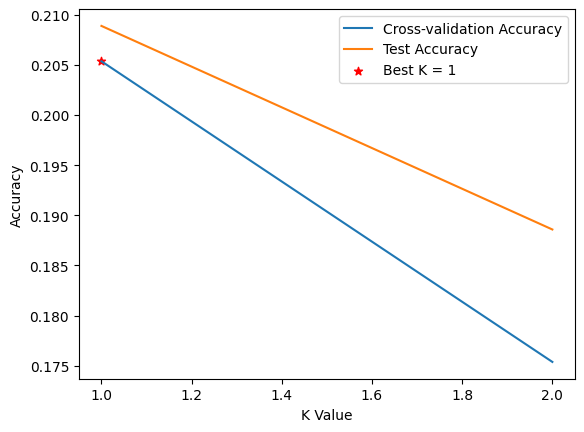

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score

# Define the range of K values to try
k_values = range(1, 3)

# Lists to store cross-validation and test accuracies
cv_accuracies = []
test_accuracies = []

# Perform grid search
for k in k_values:
    # Create a KNN classifier with the current K
    knn_classifier = KNNClassifier(k=k)

    # Cross-validation using scikit-learn's KFold
    kf = KFold(n_splits=2, shuffle=True, random_state=42)
    fold_accuracies = cross_val_score(knn_classifier, X_train, y_train, cv=kf, scoring='accuracy')
    
    # Calculate mean cross-validation accuracy for this K
    cv_accuracy = np.mean(fold_accuracies)
    cv_accuracies.append(cv_accuracy)

    # Fit the model on the entire training set with the current K
    knn_classifier.fit(X_train, y_train)

    # Make predictions on the test set
    predictions_test = knn_classifier.predict(X_test)

    # Calculate test accuracy for this K
    test_accuracy = accuracy_score(y_test, predictions_test)
    test_accuracies.append(test_accuracy)

best_k = k_values[np.argmax(cv_accuracies)]

# Plot the results
plt.plot(k_values, cv_accuracies, label='Cross-validation Accuracy')
plt.plot(k_values, test_accuracies, label='Test Accuracy')
plt.scatter(best_k, max(cv_accuracies), color='red', marker='*', label=f'Best K = {best_k}')
plt.xlabel('K Value')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

<h3> Which model gives the best accuracy and why?</h3>

### Answer:

PCA helped reduce the number of features from 1000 to only 400 and this reduced the computational complexity little bit. Although the accuracy was now only marginally better (~0.88%), the number of dimensions we got rid off likely prevented us from running into the curse of dimensionality, allowing faster computations. This marginal improvement also indicates that PCA may speed up calculation without affecting the classification accuracy of all features greatly.

#### Optimal Model

The best configuration of the k-NN model was found to be k-NN with PCA and k=3, with an accuracy of 17.71%

#### Working better due to:

Dimensionality Reduction: Through PCA, the features which were a total of 1000 were lessened to mere 400, and hence minimizing the effect of curse of dimensionality. PCA probably dispensed with noise and irrelevant features.

Improved Generalization: With fewer dimensions, the model avoids overfitting to high-dimensional noise, leading to better generalization across different data splits.

Computational Efficiency: PCA reduced the complexity of calculating distances between data points, enabling faster and potentially more accurate classification.

Class Separability: The PCA transformation reorganized the feature space to maximize variance, which might have improved the separability of overlapping class distributions.